In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [13]:
# Load pre-processed data
Gold_CRC_BA = pd.read_csv("SingaporeCRC_data/genus_strictfilted_clr.csv", index_col=0, delimiter=",")
Gold_CRC_BA = Gold_CRC_BA.T

Gold_CRC_GE = pd.read_csv("SingaporeCRC_data/MSIde_exp.csv", index_col=0, delimiter=",")
Gold_CRC_GE = Gold_CRC_GE.T

In [14]:
Combined_Gold = pd.concat([Gold_CRC_BA, Gold_CRC_GE], axis=1)
pid = Combined_Gold.index #.astype('float')
Combined_Gold.insert(0,'patient_id',pid)
Combined_Gold

,patient_id,g__Paraburkholderia,g__Lautropia,g__Roseateles,g__Aquincola,g__Piscinibacter,g__Sphaerotilus,g__Caldimonas,g__Rubrivivax,g__Methylibium,...,PWRN3,CKBP1,LINC01195,UBE2FP2,LINC01177,KRT23,CRAT40,MIR4686,MIR5692C1,RPL23AP77
X47,X47,-0.131743,-0.642569,4.045716,1.785179,1.814167,1.031408,0.823768,1.203258,0.897876,...,0.045355,0.011381,0.000000,1.920003,0.000000,0.075379,0.079571,0.000000,0.000000,0.034402
X95,X95,-2.122681,1.343055,1.731006,-0.547145,-0.918708,-1.024069,-1.516545,-1.275383,-1.968530,...,0.015792,0.000000,0.036489,0.069617,0.110965,4.688636,1.464491,1.441577,1.818222,0.035117
X106,X106,-1.102375,-0.090774,2.804636,0.912528,0.344544,-0.186084,-0.409227,-0.291444,-0.409227,...,0.000000,0.013645,0.042427,0.000000,0.000000,0.267061,0.000000,0.000000,0.684246,0.119170
X153,X153,-1.102788,-0.815106,3.205771,1.295107,1.017475,0.688971,-0.121959,0.196495,-0.815106,...,0.000000,0.026477,0.000000,0.077683,0.063250,4.837088,3.022642,0.000000,2.343012,0.000000
X326,X326,-1.704407,-1.704407,2.406466,-0.094969,0.167395,0.000341,-0.094969,-0.451644,-0.200330,...,0.019591,0.000000,0.000000,0.086342,0.000000,1.407463,0.000000,0.793259,0.000000,0.127261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1625,X1625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.294912,0.000000,0.150599,0.000000,0.117262,4.799470,0.814038,0.000000,1.268254,0.098166
X1054,X1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.157672,1.270044,0.124537,0.283270,0.118665,0.000000,0.000000,0.052460
X1378,X1378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.282383,0.000000,0.263816,0.000000,0.128039,3.621631,1.191623,1.454094,1.774499,0.107100
X1254,X1254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.887996,0.061925,0.094347,0.000000,0.276958,5.657773,3.578145,0.000000,1.613074,0.134316


In [15]:
metadata = pd.read_csv("SingaporeCRC_data/filtered_metadata.csv", index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata = metadata.drop(['SMAD4', 'RNF43'], axis = 1)
metadata

,patient_id,TMB,KRAS,BRAF,NRAS,TP53,APC,PIK3CA,PIK3R1,ERBB4,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
3,X106,1028,wt,wt,wt,wt,wt,wt,wt,wt,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X153,80,mut,wt,wt,mut,mut,mut,wt,wt,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
5,X326,1512,mut,wt,wt,wt,wt,wt,wt,mut,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
7,X420,1976,mut,wt,wt,mut,mut,wt,wt,wt,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
8,X470,739,wt,wt,wt,wt,wt,wt,mut,wt,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,X1658,82,mut,wt,wt,mut,mut,wt,wt,wt,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
143,X1662,74,mut,wt,wt,mut,wt,wt,wt,wt,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
144,X1664,46,mut,wt,wt,mut,wt,wt,wt,wt,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
145,X1665,93,mut,wt,wt,mut,mut,wt,wt,wt,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [16]:
SG_Gold_CRC_combined = pd.merge(Combined_Gold, metadata, on='patient_id', how='inner')
SG_Gold_CRC_combined

,patient_id,g__Paraburkholderia,g__Lautropia,g__Roseateles,g__Aquincola,g__Piscinibacter,g__Sphaerotilus,g__Caldimonas,g__Rubrivivax,g__Methylibium,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,X106,-1.102375,-0.090774,2.804636,0.912528,0.344544,-0.186084,-0.409227,-0.291444,-0.409227,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
1,X153,-1.102788,-0.815106,3.205771,1.295107,1.017475,0.688971,-0.121959,0.196495,-0.815106,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
2,X326,-1.704407,-1.704407,2.406466,-0.094969,0.167395,0.000341,-0.094969,-0.451644,-0.200330,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
3,X420,-1.752891,-1.752891,2.436764,0.144229,0.144229,-0.453608,-0.772061,-0.654278,-0.286554,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X470,-2.373698,-3.184628,0.433024,-1.105187,-1.737709,-2.086016,-3.472310,-2.086016,-2.373698,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,X1658,-1.465540,-2.158687,3.056249,1.173518,0.731685,0.143898,-0.549249,-1.465540,-0.772392,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
107,X1662,-3.295067,-2.447769,0.675225,-1.560466,-1.828730,-2.091094,-2.447769,-3.007385,-2.784241,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
108,X1664,-1.271815,-1.271815,3.732131,1.772708,1.618557,1.030770,-0.173203,0.114480,-0.173203,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
109,X1665,-1.983832,-1.983832,3.169460,1.194222,0.906540,0.724218,0.788757,-0.192072,0.095610,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [17]:
class_counts = SG_Gold_CRC_combined['MSI.Status'].value_counts()
print(class_counts)

MSI.Status
MSS    87
MSI    24
Name: count, dtype: int64


In [18]:
# Prepare features and target variable
X = SG_Gold_CRC_combined.drop(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'ERBB4', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_Gold_CRC_combined['MSI.Status']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['MSI' 'MSS']
Unique values of y: [0 1]
Shape of y: (111, 477)
Shape of y: (111,)


In [19]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X, y)

print(X_scaled.shape)
print(y.shape)

(174, 477)
(174,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}
Best Score: 0.9836666666666666
Test Set Accuracy: 0.9811320754716981


<Figure size 800x600 with 0 Axes>

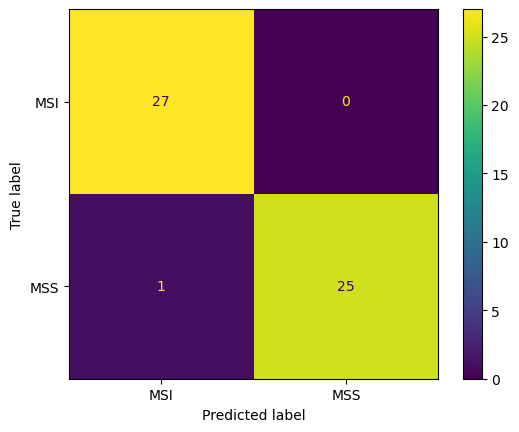

              precision    recall  f1-score   support

         MSI       0.96      1.00      0.98        27
         MSS       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.98      0.98        53
weighted avg       0.98      0.98      0.98        53



In [20]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [20, 50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MSI', 'MSS'])
plt.figure(figsize=(8, 6)) 
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['MSI', 'MSS'])
print(report)

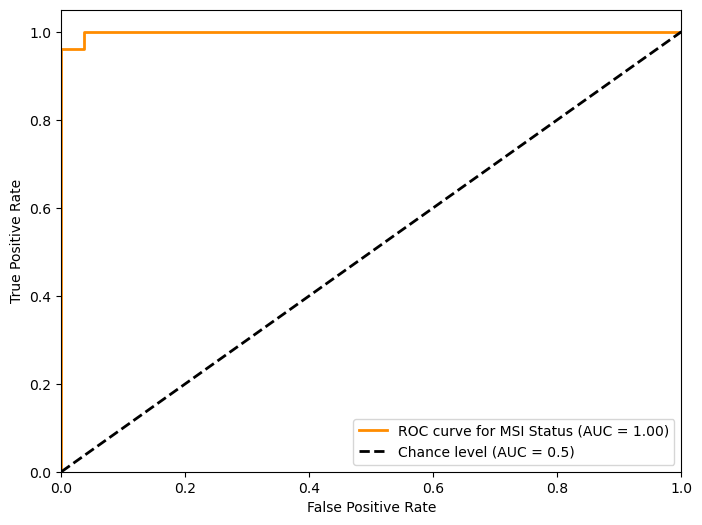

In [21]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for MSI Status (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_17672\951501840.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


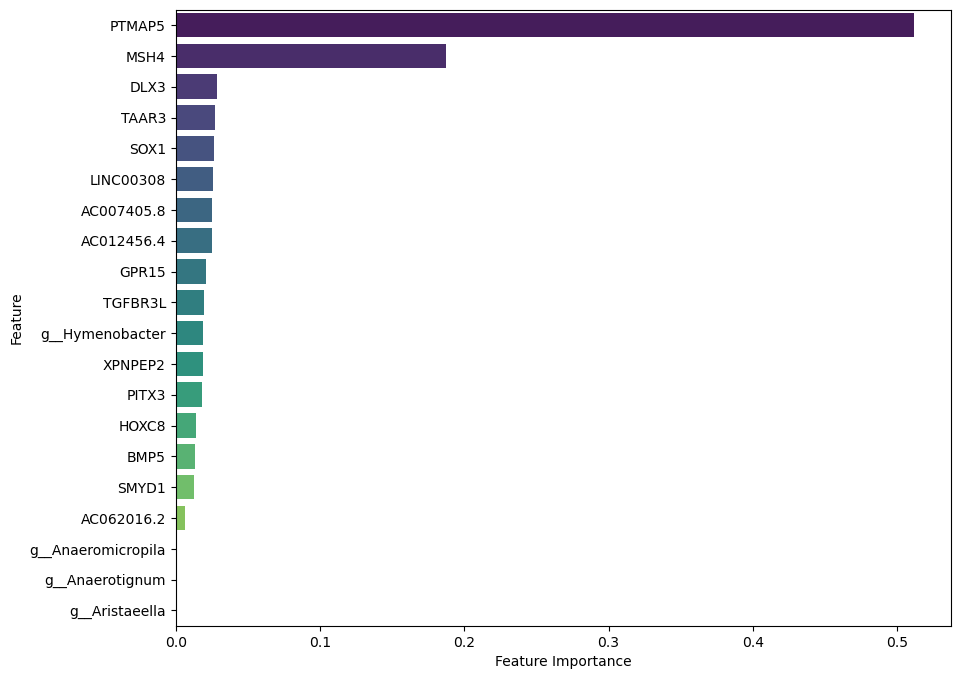

In [22]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()